In [1]:
import torch
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

import legacyMTT
from deepMTT import BabyUNet

from simulate.simulate_camera import get_camera_image 
from simulate.simulate_camera import add_molecule

In [2]:
from simulate.simulate_test_data import simulate_test_data

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
%matplotlib inline

In [7]:
def count_loss(bernoulli_map, N):
    N_est = bernoulli_map.sum(dim=2).sum(dim=2).squeeze(1)
    var_est = (bernoulli_map*(1-bernoulli_map)).sum(dim=2).sum(dim=2).squeeze(1)
    var_est = var_est+1e-10 #adding pseudocounts to prevent nans
    log_loss = (N_est-N)**2/2/var_est+torch.log(torch.sqrt(2*np.pi*var_est))
    log_loss -= torch.log(torch.sqrt(torch.tensor(2*np.pi*1e-10))) #removing the pseudocount loss to re-zero the second term of the function. 
    log_loss = log_loss.mean()
    return log_loss

In [8]:
sigmoid = torch.nn.Sigmoid()

In [9]:
bernoulli_map = sigmoid(1*(torch.rand(6,1,20,20)-0.5))

In [10]:
count_loss(bernoulli_map, 200)

tensor(13.8105)

In [11]:
device = 'cpu'
detection_model = BabyUNet().to(device)

In [12]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(detection_model.parameters(), lr=learning_rate)

loss_fn_map = torch.nn.BCELoss()    
loss_fn_counts = torch.nn.MSELoss()

In [13]:
running_loss = 0.
for t in range(5000):
    n_pix = np.random.randint(467)+45
    n_mols_in = np.random.randint(18)+3
    X, det_map, n_mols = simulate_test_data(n_pix=n_pix, mols_per_frame = n_mols_in)
    map_est = detection_model(X)
    loss = loss_fn_map(map_est, det_map) + 100*count_loss(map_est, torch.tensor(n_mols).float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+= loss.item()
    if t % 100 == 0:
        print(t, loss.item())
        print(t, running_loss/100)
        running_loss = 0.

/Users/oandrews/miniconda3/envs/deepFit/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/oandrews/miniconda3/envs/deepFit/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/Users/oandrews/miniconda3/envs/deepFit/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().d

0 16841357312.0
0 168413573.12
100 5689095.0
100 121293448.23125
200 3259687.0
200 7622050.574375
300 4984650.0
300 6194905.71984375
400 2843372.75
400 6919777.335
500 3982942.0
500 7237758.080625
600 205371.546875
600 5845394.93515625
700 17540312.0
700 7815557.8675
800 2916685.75
800 6560493.12984375
900 9475310.0
900 7256017.8390625
1000 10735189.0
1000 6437192.91484375
1100 1271182.75
1100 6247765.86578125
1200 526360.9375
1200 6216034.56375
1300 3034777.75
1300 7485468.80609375
1400 6326703.5
1400 5456568.965625
1500 7178373.0
1500 5626738.85890625
1600 1353576.5
1600 6627527.711875
1700 3274292.25
1700 7190055.590625
1800 1003824.0
1800 7144434.88125
1900 12605024.0
1900 6711765.84296875
2000 8801402.0
2000 6293986.695625
2100 17290904.0
2100 7036478.565625
2200 15629723.0
2200 6748620.66578125
2300 142329.296875
2300 6978852.0228125
2400 10828848.0
2400 6075241.0334375
2500 396867.875
2500 6786195.62015625
2600 10058026.0
2600 6230415.97890625
2700 4531053.0
2700 6760780.659375


In [14]:
X, det_map, n_mols = simulate_test_data()
map_est = detection_model(X)
loss = loss_fn_map(map_est, det_map) + count_loss(map_est, torch.tensor(n_mols).float())
loss.item()

/Users/oandrews/miniconda3/envs/deepFit/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


9134.5009765625

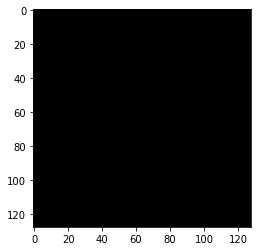

In [15]:
plt.imshow(map_est.squeeze().detach(), cmap = 'gray')

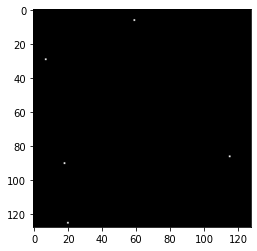

In [16]:
plt.imshow(det_map.squeeze().detach(), cmap = 'gray')

In [17]:
torch.max(map_est)

tensor(0.5270, grad_fn=<MaxBackward1>)

In [18]:
count_loss(map_est, torch.tensor(n_mols).float())

/Users/oandrews/miniconda3/envs/deepFit/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor(9133.7520, grad_fn=<MeanBackward0>)

In [19]:
map_est

tensor([[[[0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
          [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
          [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
          ...,
          [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
          [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
          [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270]]]],
       grad_fn=<SliceBackward>)

In [20]:
map_est.squeeze()

tensor([[0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
        [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
        [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
        ...,
        [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
        [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270],
        [0.5270, 0.5270, 0.5270,  ..., 0.5270, 0.5270, 0.5270]],
       grad_fn=<SqueezeBackward0>)

In [21]:
torch.min(map_est)

tensor(0.5270, grad_fn=<MinBackward1>)

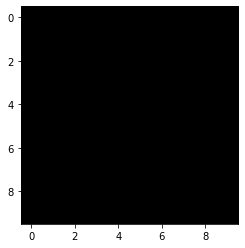

In [22]:
plt.imshow(map_est.squeeze().detach()[0:10,0:10], cmap = 'gray')

In [23]:
learning_rate = 1e-5
optimizer = torch.optim.Adam(detection_model.parameters(), lr=learning_rate)

loss_fn_map = torch.nn.BCELoss()    
loss_fn_counts = torch.nn.MSELoss()

In [24]:
running_loss = 0.
for t in range(10000):
    n_pix = np.random.randint(467)+45
    n_mols_in = np.random.randint(18)+3
    X, det_map, n_mols = simulate_test_data(n_pix=n_pix, mols_per_frame = n_mols_in)
    map_est = detection_model(X)
    loss = loss_fn_map(map_est, det_map) + count_loss(map_est, torch.tensor(n_mols).float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+= loss.item()
    if t % 100 == 0:
        print(t, loss.item())
        print(t, running_loss/100)
        running_loss = 0.

/Users/oandrews/miniconda3/envs/deepFit/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


0 6994.84033203125
0 69.9484033203125
100 70971.9375
100 51090.52436401367
200 131946.984375
200 57677.745986328126
300 123842.9609375
300 57537.775451660156
400 19854.26953125
400 52569.25546630859
500 16226.5966796875
500 59930.409145507816
600 68323.15625
600 55681.139884033204


KeyboardInterrupt: 

In [ ]:
loss_fn_map(map_est, det_map)

In [25]:
model_parameters = filter(lambda p: p.requires_grad, detection_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [26]:
params

7613